In [36]:
%load_ext autoreload
%autoreload 2
import sys
from gensim.utils import tokenize
import pandas as pd
import numpy as np
import re
import transformers
from sklearn.preprocessing import LabelEncoder
import os
import re
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print("TensorFlow version: ", tf.__version__)
import tensorflow_hub as hub
from utils import *
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
import plotly.express as px
import plotly.graph_objects as go
#import bert
import torch
import torch.nn as nn
import gensim
import sys
import string
import logging
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from gensim.models import word2vec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TensorFlow version:  2.18.0


In [37]:
%pip install scikit-learn
%pip install tensorflow_hub
%pip install matplotlib
%pip install plotly

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
colnames=['image_path', 'text', 'food']
train = pd.read_csv('train_titles.csv', names=colnames, header=None, sep = ',', index_col=['image_path'])
test = pd.read_csv('test_titles.csv', names=colnames, header=None, sep = ',', index_col=['image_path'])
# Sort values by 'image_path'
test = test.sort_values('image_path')
train = train.sort_values('image_path')
train.head()



,text,food
image_path,,
apple_pie_0.jpg,Apple pie - Wikipedia,apple_pie
apple_pie_100.jpg,Glazed Apple Pie Squares Recipe | Taste of Home,apple_pie
apple_pie_101.jpg,Mock Apple Pie Recipe - Allrecipes.com,apple_pie
apple_pie_102.jpg,Crock-Pot Ladies Crock-Pot Apple Pie Moonshine,apple_pie
apple_pie_104.jpg,All-Star Apple Pie Recipe | Taste of Home,apple_pie


In [39]:
# Check the shapes
print("train samples:",train.shape[0])
print("test samples:",test.shape[0])
vec_preprocess_text = np.vectorize(preprocess_text)
processed_train = vec_preprocess_text(train.text.values.tolist() + test.text.values.tolist())
print(train.text.values.tolist()[0])
print(processed_train[0])


train samples: 67972
test samples: 22716
Apple pie - Wikipedia
apple pie wikipedia


### Sequence Length Histograms

Text(0.5, 1.0, 'Sentence lengths in input data')

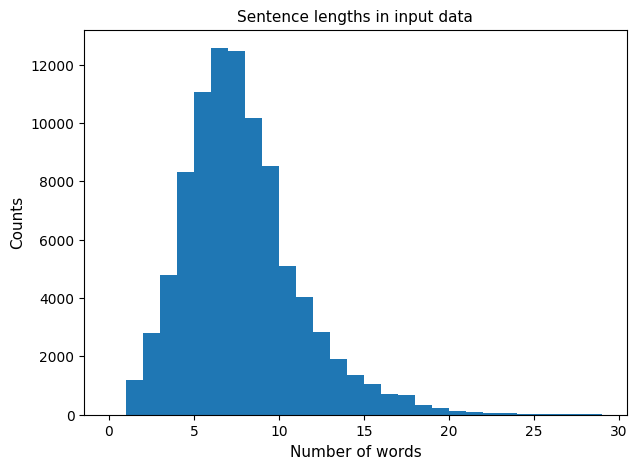

In [40]:
listData = [list(tokenize(processed_train[i])) for i in range(processed_train.shape[0])]
lengths = [len(listData[i]) for i in range(len(listData))]
fig,ax = plt.subplots(figsize = (7,5))
ax.hist(lengths,bins = range(0,30,1))
ax.set_ylabel('Counts', fontsize = 11)
ax.set_xlabel('Number of words', fontsize =11)
ax.set_title('Sentence lengths in input data', fontsize = 11)

### Fit Word2vec on entire dataset

In [41]:
dim = 100                 
w2vModel = word2vec.Word2Vec(listData, vector_size=dim,min_count=1)
# add default key, that is, value for unknown key, may happen during testing
w2vModel.wv.add_vector(0,np.zeros((dim)))
w2v_weights = w2vModel.wv.vectors

print(w2vModel.wv.most_similar('barbecue',topn=3))
print(w2vModel.wv.most_similar('apple',topn=3))
print(w2vModel.wv.most_similar('falafel',topn=3))

[('babyback', 0.8964715600013733), ('breaded', 0.8516974449157715), ('bbq', 0.8488963842391968)]
[('crostata', 0.756614625453949), ('flakey', 0.7185269594192505), ('pumpkin', 0.7029182314872742)]
[('hummus', 0.803119421005249), ('dressing', 0.7635035514831543), ('effervescent', 0.751530110836029)]


c:\Users\vm-user\AppData\Local\Programs\Python\Python310\lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(
c:\Users\vm-user\AppData\Local\Programs\Python\Python310\lib\site-packages\gensim\models\keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


### Map Captions to Tokens to IDs and Assign Labels

In [42]:
numClasses = 101
# optionally downsample by reducing the number of classes 
#train,test = downSampleData(numClasses, train, test)
countsTrn,countsTst  = classCounts(numClasses, train, test)
processed_train = vec_preprocess_text(train.text.values)
processed_test = vec_preprocess_text(test.text.values)
print(processed_train[0])
print(processed_test[0])
# get train and test labels
encoder = LabelEncoder()
encoded_labels_train = encoder.fit_transform(train.food.values)
encoded_labels_test = encoder.fit_transform(test.food.values)
# map train and test tokens to ids
maxLen = 32
processed_train = [list(tokenize(processed_train[i])) for i in range(processed_train.shape[0])]
idsTrn = token2id(processed_train, maxLen, w2vModel)
processed_test = [list(tokenize(processed_test[i])) for i in range(processed_test.shape[0])]
idsTst = token2id(processed_test, maxLen, w2vModel)

apple pie wikipedia
apple pie and cake recipes health com


In [43]:
class w2nModel(torch.nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_size, nClasses):
        super(w2nModel, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_size,batch_first=True)
        #self.bn = nn.BatchNorm1d(hidden_size)
        self.drop1 = nn.Dropout(p = 0.5)
        self.FC1 = nn.Linear(hidden_size,256)
        self.drop2 = nn.Dropout(p = 0.5)
        self.FC2 = nn.Linear(256,nClasses)
        self.Relu = torch.nn.ReLU()


    def forward(self, x):
        x = self.word_embeddings(x) # output dimensions is batch size = N x sequence length x feature size
        (x,_) = self.LSTM(x)        
        x = x[:, -1, :] # gives two dimensional output, not three dimensional output
        #x = self.bn(x)
        x = self.drop1(x)               
        x = self.Relu(self.FC1(x))
        x = self.drop2(x)
        x = self.FC2(x)
        return x

### Train Neural Net

In [44]:
#from torchsummary import summary
torch.device('cuda:0')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#device = 'gpu'
batchSize = 512
hidden_size = 64
model = w2nModel(vocab_size = w2v_weights.shape[0], 
                 embedding_dim = w2v_weights.shape[1],
                 hidden_size=hidden_size, nClasses = numClasses
                )
model.word_embeddings.weight.data.copy_(torch.from_numpy(w2v_weights))
model.word_embeddings.weight.requires_grad=False

labels_train = torch.tensor(encoded_labels_train).long()
#print(torch.max(labels_train))
trainloader = torch.utils.data.DataLoader(list(zip(idsTrn.int(), labels_train)), batch_size=batchSize,
                                         shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
lossVals = []
model = model.to(device)
print(model)

cpu
w2nModel(
  (word_embeddings): Embedding(22324, 100)
  (LSTM): LSTM(100, 64, batch_first=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (FC1): Linear(in_features=64, out_features=256, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (FC2): Linear(in_features=256, out_features=101, bias=True)
  (Relu): ReLU()
)


In [45]:
for epoch in range(50):  # loop over the dataset multiple times
    for i, data in enumerate(trainloader):
        inputs,labels = data
        inputs = inputs.to(device) 
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        lossVals.append(loss.detach().cpu().numpy())
        optimizer.step()
    if epoch%5 == 0:
        print(loss)
print('Finished Training')

tensor(4.6119, grad_fn=<NllLossBackward0>)
tensor(4.6009, grad_fn=<NllLossBackward0>)
tensor(3.5475, grad_fn=<NllLossBackward0>)
tensor(2.6271, grad_fn=<NllLossBackward0>)
tensor(1.7585, grad_fn=<NllLossBackward0>)
tensor(1.5035, grad_fn=<NllLossBackward0>)
tensor(1.3935, grad_fn=<NllLossBackward0>)
tensor(1.6189, grad_fn=<NllLossBackward0>)
tensor(1.5655, grad_fn=<NllLossBackward0>)
tensor(1.2402, grad_fn=<NllLossBackward0>)
Finished Training


In [25]:
labels_test = torch.tensor(encoded_labels_test).long()
testLoader = torch.utils.data.DataLoader(list(zip(idsTst.int(), labels_test)), batch_size=batchSize,
                                         shuffle=True)
# again no gradients needed
model.eval()
correct_pred = 0
with torch.no_grad():
    for data in testLoader:
        inputs, labels = data
        inputs = inputs.to(device) 
        labels = labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred += 1

accuracy = 100 * float(correct_pred)/ idsTst.shape[0]
print(accuracy)

80.07131537242472


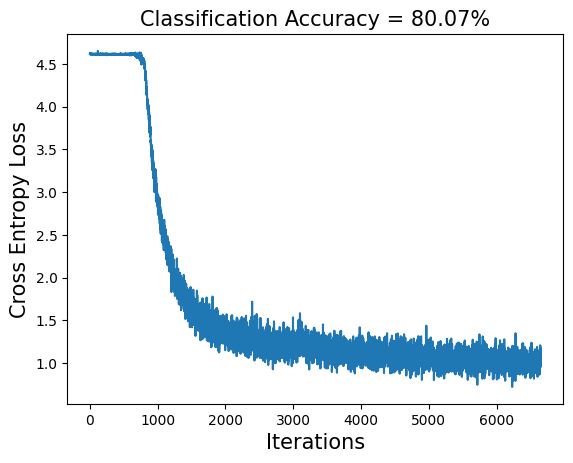

In [26]:
fig, ax = plt.subplots(nrows = 1, ncols=1)
ax.plot(range(len(lossVals)),lossVals)
ax.set_xlabel('Iterations',fontsize = 15)
ax.set_ylabel('Cross Entropy Loss', fontsize = 15)
ax.set_title('Classification Accuracy = {:.2f}%'.format(accuracy),fontsize = 15)
path = 'dim_{}_accry_{:.2f}len_{}_hidden_{}'.format(dim,accuracy, maxLen,hidden_size)
plt.savefig(path+'.pdf')

### Get 5 Most Error-Full Classes

In [27]:
path = os.getcwd()
checkpoint_path = path+'\_accrcy_{:.2f}_dim_{}.pt'.format(accuracy,dim)
print(checkpoint_path)
torch.save(model, checkpoint_path)

c:\Users\vm-user\Documents\GitHub\Food_101\_accrcy_80.07_dim_100.pt


# SVM with LSTM

### Declare LSTM model

In [28]:
class w2nModelSVM(torch.nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_size, nClasses):
        super(w2nModelSVM, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_size,batch_first=True)

    def forward(self, x):
        x = self.word_embeddings(x)     # output dimensions is batch size = N x sequence length x feature size
        (x,_) = self.LSTM(x)        
        x = x[:, -1, :]                 # gives two dimensional output, not three dimensional output
        return x

torch.device('cuda:0')
modelSVM = w2nModelSVM(vocab_size = w2v_weights.shape[0], 
                 embedding_dim = w2v_weights.shape[1],
                 hidden_size=hidden_size, nClasses = numClasses
                )
modelSVM.word_embeddings.weight.data.copy_(torch.from_numpy(w2v_weights))
modelSVM.word_embeddings.weight.requires_grad=False
modelSVM.LSTM.load_state_dict(model.LSTM.state_dict())
modelSVM.LSTM.requires_grad_=False

### Get LSTM Embeddings for Train and Test Dataset

In [29]:
labels_train = torch.tensor(encoded_labels_train).long()
trainloader = torch.utils.data.DataLoader(list(zip(idsTrn.int(), labels_train)), batch_size=batchSize,
                                         shuffle=True)
trnEmbdngs = np.zeros((idsTrn.shape[0],hidden_size))
trnLbls  = np.zeros((idsTrn.shape[0]))
for i, data in enumerate(trainloader):
    inputs,labels = data
    outputs = modelSVM(inputs)
    trnEmbdngs[i*batchSize: (i+1)*batchSize,:] = outputs.detach().clone().numpy()
    trnLbls[i*batchSize: (i+1)*batchSize] = labels

labels_test = torch.tensor(encoded_labels_test).long()
trainloader = torch.utils.data.DataLoader(list(zip(idsTst.int(), labels_test)), batch_size=batchSize,
                                         shuffle=True)
tstEmbdngs = np.zeros((idsTst.shape[0],hidden_size))
tstLbls  = np.zeros((idsTst.shape[0]))
for i, data in enumerate(trainloader):
    inputs,labels = data
    outputs = modelSVM(inputs)
    tstEmbdngs[i*batchSize: (i+1)*batchSize,:] = outputs.detach().clone().numpy()
    tstLbls[i*batchSize: (i+1)*batchSize] = labels

### Linear SVM


In [30]:
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo', kernel = 'linear')
clf.fit(trnEmbdngs, trnLbls)
TrnAccrcyLnr = clf.score(trnEmbdngs, trnLbls)
TstAccrcyLnr = clf.score(tstEmbdngs,tstLbls)
print(r'Train Accuracy of Linear SVM =', TrnAccrcyLnr)
print(TstAccrcyLnr)

Train Accuracy of Linear SVM = 0.8081562996527982
0.7992164113400246


### RBF Kernel SVM

In [31]:
clf = svm.SVC(decision_function_shape='ovo', kernel='rbf')
clf.fit(trnEmbdngs, trnLbls)
TrnAccrcyKernel = clf.score(trnEmbdngs, trnLbls)
TstAccrcyKernel = clf.score(tstEmbdngs,tstLbls)
print(TrnAccrcyKernel)
print(TstAccrcyKernel)

0.814820808568234
0.8049392498679345


# SVM without LSTM - Averaging Word2Vec Embeddings

In [32]:
class w2nModelSVM(torch.nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_size, nClasses):
        super(w2nModelSVM, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        x = self.word_embeddings(x)                # output dimensions is batch size = N x sequence length x feature size
        x = torch.sum(x,dim=1)/x.shape[1]          # batch size x feature size
        return x

torch.device('cuda:0')
modelw2vAvg = w2nModelSVM(vocab_size = w2v_weights.shape[0], 
                 embedding_dim = w2v_weights.shape[1],
                 hidden_size=hidden_size, nClasses = numClasses
                )
modelw2vAvg.word_embeddings.weight.data.copy_(torch.from_numpy(w2v_weights))
modelw2vAvg.word_embeddings.weight.requires_grad=False


In [33]:
labels_train = torch.tensor(encoded_labels_train).long()
trainloader = torch.utils.data.DataLoader(list(zip(idsTrn.int(), labels_train)),
                                         batch_size=batchSize,
                                         shuffle=True)
trnEmbdngs = np.zeros((idsTrn.shape[0],dim))
trnLbls  = np.zeros((idsTrn.shape[0]))
for i, data in enumerate(trainloader):
    inputs,labels = data
    outputs = modelw2vAvg(inputs)
    trnEmbdngs[i*batchSize: (i+1)*batchSize,:] = outputs.detach().clone().numpy()
    trnLbls[i*batchSize: (i+1)*batchSize] = labels

labels_test = torch.tensor(encoded_labels_test).long()
trainloader = torch.utils.data.DataLoader(list(zip(idsTst.int(), labels_test)), batch_size=batchSize,
                                         shuffle=True)
tstEmbdngs = np.zeros((idsTst.shape[0],dim))
tstLbls  = np.zeros((idsTst.shape[0]))
for i, data in enumerate(trainloader):
    inputs,labels = data
    outputs = modelw2vAvg(inputs)
    tstEmbdngs[i*batchSize: (i+1)*batchSize,:] = outputs.detach().clone().numpy()
    tstLbls[i*batchSize: (i+1)*batchSize] = labels

In [34]:
clf = svm.SVC(decision_function_shape='ovo', kernel = 'linear')
clf.fit(trnEmbdngs, trnLbls)
TrnAccrcyLnr = clf.score(trnEmbdngs, trnLbls)
TstAccrcyLnr = clf.score(tstEmbdngs,tstLbls)
print(TrnAccrcyLnr)
print(TstAccrcyLnr)

0.738730653798623
0.7306303926747667


In [35]:
clf = svm.SVC(decision_function_shape='ovo', kernel='rbf')
clf.fit(trnEmbdngs, trnLbls)
TrnAccrcyKernel = clf.score(trnEmbdngs, trnLbls)
TstAccrcyKernel = clf.score(tstEmbdngs,tstLbls)
print(TrnAccrcyKernel)
print(TstAccrcyKernel)

0.773583240157712
0.7437929212889594
